### Import Library

In [1]:
import numpy as np
import pandas as pd

import pickle

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../')

In [3]:
from importlib import reload

from custom_function import minimalSARIMAX

reload(minimalSARIMAX)

from custom_function.minimalSARIMAX import MinimalSARIMAX

### Import Train and Test sets

In [4]:
train_set = pd.read_csv('6Hsampled_data_set/SURAT/train_set.csv')
train_set['WindDirSin'] = np.sin(train_set['WindDir'])*10 + 10
train_set['WindDirCos'] = np.cos(train_set['WindDir'])*10 + 10 
train_set['Time'] = pd.to_datetime(train_set['Time'])
train_set = train_set.set_index('Time')

valid_set = pd.read_csv('6Hsampled_data_set/SURAT/valid_set.csv')
valid_set['WindDirSin'] = np.sin(valid_set['WindDir'])*10 + 10 
valid_set['WindDirCos'] = np.cos(valid_set['WindDir'])*10 + 10 
valid_set['Time'] = pd.to_datetime(valid_set['Time'])
valid_set = valid_set.set_index('Time')

test_set = pd.read_csv('6Hsampled_data_set/SURAT/test_set.csv')
test_set['WindDirSin'] = np.sin(test_set['WindDir'])*10 + 10 
test_set['WindDirCos'] = np.cos(test_set['WindDir'])*10 + 10 
test_set['Time'] = pd.to_datetime(test_set['Time'])
test_set = test_set.set_index('Time')

### Tuning Parameters

In [5]:
order = (2, 0, 2)
seasonal_order = (0, 1, 0, 1461)

exog_order = {}
exog_order['Temp'] = (2, 0, 2)
exog_order['WindSpeed'] = (2, 1, 0)
exog_order['WindDirSin'] = (1, 0, 2)
exog_order['WindDirCos'] = (2, 0, 2)

exog_seasonal_order = {}
exog_seasonal_order['Temp'] = (0, 0, 0, 1461)
exog_seasonal_order['WindSpeed'] = (1, 0, 1, 1461)
exog_seasonal_order['WindDirSin'] = (0, 1, 0, 1461)
exog_seasonal_order['WindDirCos'] = (0, 1, 0, 1461)

exog_columns = ['Temp', 'WindSpeed', 'WindDirSin', 'WindDirCos']

### Initialize model

In [6]:
model = {}
model_exog = {}

model = MinimalSARIMAX(train_set[['PM25']],
                          order,
                          seasonal_order,
                          exog=train_set[exog_columns])
    
model_exog = {}
for exog in exog_columns:
    model_exog[exog] = MinimalSARIMAX(train_set[[exog]],
                                      exog_order[exog],
                                      exog_seasonal_order[exog])

### Train exogenous models

In [7]:
model.fit(lr=1e-6, lr_decay=0.999 ,verbose=0)

for exog in exog_columns:
        model_exog[exog].fit(lr=1e-6, lr_decay=0.999, verbose=0)
        _ = model_exog[exog].predict_step(train_set[[exog]],
                                          valid_set[[exog]], 
                                          lr=np.array([1e-6]), lr_decay=0.999875, lr_decay_iter=0.95,
                                          step=12, n_iter=1, learn=True, verbose=1)

100%|██████████| 2555/2555 [02:37<00:00, 16.21it/s]


ITER#0  RMSE:8.163704204987777


100%|██████████| 2555/2555 [02:31<00:00, 16.84it/s]


ITER#0  RMSE:10.631634826197201


100%|██████████| 2555/2555 [02:39<00:00, 16.02it/s]


ITER#0  RMSE:11.09781593016542


100%|██████████| 2555/2555 [02:36<00:00, 16.31it/s]

ITER#0  RMSE:10.346695990814933


### Train PM2.5 model with exogenous models

In [8]:
Result_train = model.predict_step(train_set[['PM25']],
                                  valid_set[['PM25']], 
                                  val_X_exog=train_set[exog_columns],
                                  y_exog=valid_set[exog_columns], 
                                  model_exog=model_exog,
                                  lr=np.array([5e-6, 5e-7, 5e-7, 5e-7, 5e-7]), lr_decay=0.999, lr_decay_iter=0.95,
                                  step=12, n_iter=10, learn=True, verbose=1)

train_pred_sav, val1_pred_sav, Error_save = Result_train

100%|██████████| 2555/2555 [09:43<00:00,  4.38it/s]


ITER#0  RMSE:8.922508441159156


100%|██████████| 2555/2555 [09:45<00:00,  4.37it/s]


ITER#1  RMSE:9.129292675576643


100%|██████████| 2555/2555 [09:48<00:00,  4.34it/s]


ITER#2  RMSE:8.835640784813789


100%|██████████| 2555/2555 [09:37<00:00,  4.43it/s]


ITER#3  RMSE:8.650533593620436


100%|██████████| 2555/2555 [09:42<00:00,  4.39it/s]


ITER#4  RMSE:8.48964178671942


100%|██████████| 2555/2555 [08:48<00:00,  4.83it/s]


ITER#5  RMSE:8.342023728067069


100%|██████████| 2555/2555 [08:48<00:00,  4.83it/s]


ITER#6  RMSE:8.200440564970519


100%|██████████| 2555/2555 [08:53<00:00,  4.79it/s]


ITER#7  RMSE:8.062071369653538


100%|██████████| 2555/2555 [09:38<00:00,  4.42it/s]


ITER#8  RMSE:7.922812788151147


100%|██████████| 2555/2555 [08:55<00:00,  4.77it/s]

ITER#9  RMSE:7.780847328066739


In [9]:
model.params

{'p': array([0.33518113, 0.29861999]),
 'pX': array([0.0272451 , 0.0173535 , 0.06839994, 0.04594744]),
 'd': array([0.]),
 'q': array([0.16215275, 0.1523497 ]),
 'P': array([0.]),
 'D': array([0.20401355]),
 'Q': array([0.]),
 'c': 0.11829954995906446}

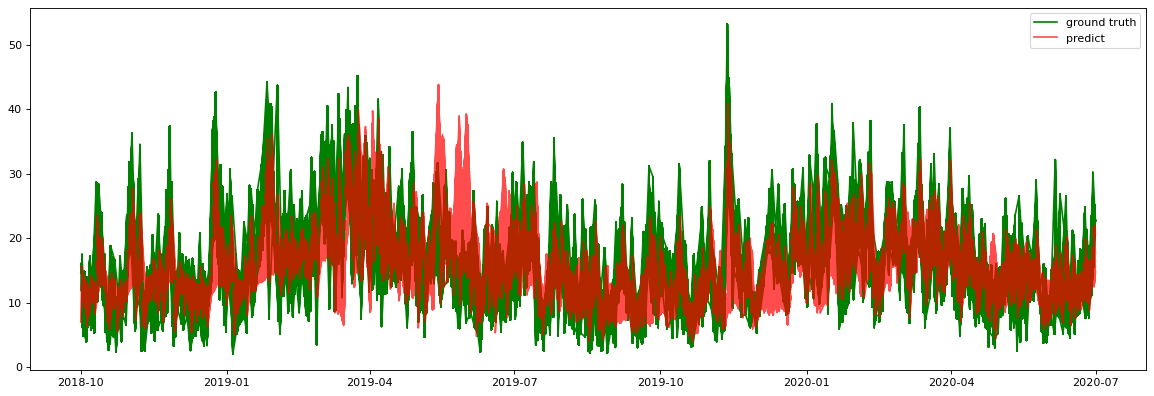

In [10]:
train_X = pd.concat([train_pred_sav, val1_pred_sav])
train_X = train_X.set_index('Time')

plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_X['Actual'], color='g', label='ground truth')
plt.plot(train_X['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

#### Dump PM2.5 model and exog models

In [11]:
with open('./model_save/surat/model_surat.model',"wb") as f:
    pickle.dump(model, f)

with open('./model_save/surat/model_surat_exog.model',"wb") as f:
    pickle.dump(model_exog, f)

#### Load PM2.5 model and exog models

In [12]:
model = pickle.load(open('./model_save/surat/model_surat.model', 'rb'))
model_exog = pickle.load(open('./model_save/surat/model_surat_exog.model', 'rb'))

### Predict on test set

In [13]:
Result_test = model.predict_step(valid_set[['PM25']],
                                 test_set[['PM25']], 
                                 val_X_exog=valid_set[exog_columns],
                                 y_exog=test_set[exog_columns], 
                                 model_exog=model_exog,
                                 lr=np.array([5e-7, 5e-7, 5e-7, 5e-7, 5e-7]), lr_decay=0.999875,
                                 step=12, n_iter=1, learn=True, verbose=1)	

val2_pred_sav, test_pred_sav, Error_save = Result_test

100%|██████████| 2230/2230 [07:12<00:00,  5.16it/s]

ITER#0  RMSE:7.307726191027386


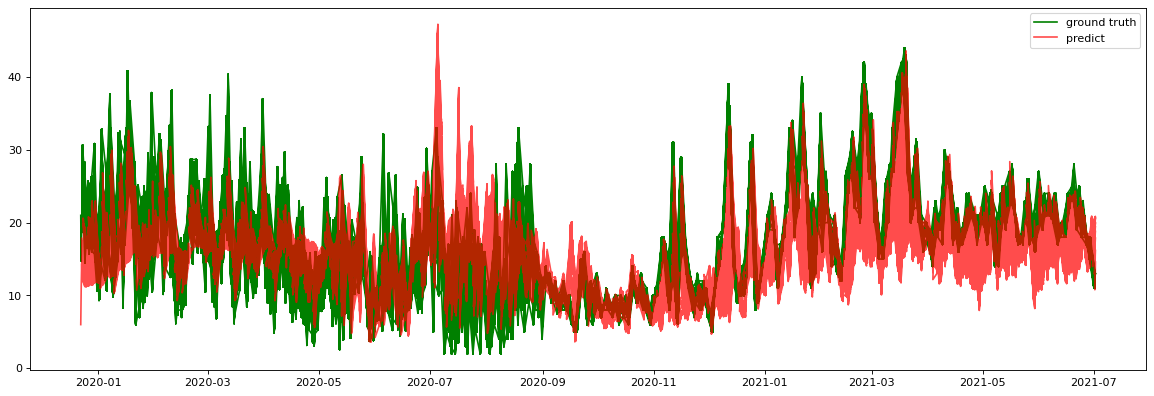

In [14]:
test_X = pd.concat([val2_pred_sav, test_pred_sav])
test_X = test_X.set_index('Time')

plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test_X['Actual'], color='g', label='ground truth')
plt.plot(test_X['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

In [15]:
test_pred_sav.to_csv('../answer_dataset/pred_and_actual/y_pred_sav_SURAT.csv')